# StateClustering.ipynb
## State clustering—categorical and positional clustering of inferred model states

Here I will investigate the degree to which learned (inferred) states from hidden Markov models (HMMs) cluster in categorical space (e.g., RUN vs NORUN, SWR vs NOSWR, Lin1 vs Lin2, Lin1a-long vs Lin1b-short, etc.) as well as in positional space (state probability as a function of space. à la place fields).

In particular, I expect (hope) that the spatial clustering will look nice, and resemble actual place fields, but we can't reasonably expect this sort of clustering to form part of our regular analysis, since we most likely won't have external positional data available (for example, when the animal is alseep).

I also hope to be able to discriminate between different categories by looking at the state clustering, because looking at the log probabilities of individual bins did not always reveal much information. For example, using bin-by-bin evaluation of observations, I could not see any difference between RUN vs NORUN epochs, although I did not leave a gap (say RUN > 8 vs NORUN < 4) in the data, and a comprehensive analysis is still lacking. In short, I hope to make faster progress by looking at state distributions and clustering, since my initial attempts to learn something directly from the log probability of a [single bin] observation proved rather fruitless.

Complementary to this notebook is ```StateOrdering.ipynb```, in which I look at both linear and 2-dimensional state ordering and associations.

### Import packages and initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

sys.path.insert(0, 'helpers')

from efunctions import * # load my helper function(s) to save pdf figures, etc.
from hc3 import load_data, get_sessions
from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn
import klabtools as klab
import seqtools as sq

import importlib

importlib.reload(sq) # reload module here only while prototyping...
importlib.reload(klab) # reload module here only while prototyping...

%matplotlib inline

sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 1.5})
sns.set_style("white")

function saveFigure(filename) loaded

Tip: to save a figure, call saveFigure("path/figure.pdf")


### Load data
Here we consider lin2 data for gor01 on the first recording day (6-7-2006), since this session had the most units (91) of all the gor01 sessions, and lin2 has position data, whereas lin1 only has partial position data.

In [11]:
datadirs = ['/home/etienne/Dropbox/neoReader/Data',
            'C:/etienne/Dropbox/neoReader/Data',
            '/Users/etienne/Dropbox/neoReader/Data']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

animal = 'gor01'; month,day = (6,7); session = '16-40-19' # 91 units

spikes = load_data(fileroot=fileroot, datatype='spikes',animal=animal, session=session, month=month, day=day, fs=32552, verbose=False)
eeg = load_data(fileroot=fileroot, datatype='eeg', animal=animal, session=session, month=month, day=day,channels=[0,1,2], fs=1252, starttime=0, verbose=False)
posdf = load_data(fileroot=fileroot, datatype='pos',animal=animal, session=session, month=month, day=day, verbose=False)
speed = klab.get_smooth_speed(posdf,fs=60,th=8,cutoff=0.5,showfig=False,verbose=False)

reading position data from 'C:\etienne\Dropbox\neoReader\Data/gor01-6-7/2006-6-7_16-40-19/2006-6-7_16-40-19.whl'
The animal (gor01) ran an average of 2.89 units/s
The animal ran faster than th = 8.0 units/s for a total of 237.7 seconds (out of a total of 2587.8 seconds).


## Part 1: Positional state clustering (à la place fields)
Here I have a few design choices that _might_ impact the results significantly. First, binning spikes: I have positional data at 60 Hz, and I have to trust that starting synchronization is pretty precise (otherwise I'm somewhat screwed). There is however no synchronization information in the .whl file itself. So I could bin the observations at 60 Hz, and then train an HMM at that timescale, or I could train a HMM at one of my usual timescales (125 ms or 62.5 ms) and then interpolate the position information.

I should also be careful to specify _what_ model I am training exactly, since usually I train on RUN data only. Should I train an HMM on all data (a training set, of course) or on RUN data only? Should I look at positional state clustering on all the data, or only on the RUN data? 

Another consideration is how I intend to compute the posterior state estimates—I could do MLSE within RUN epochs, so that I know I am getting valid state sequences, or I could do MAP decoding so that per bin, I have the posterior state estimates.

The spatial bin sizes could also make a difference, of course.

### Positional state clustering 1: RUN data only ($> 8$  u$\cdot$s$^{-1}$) @ 62.5 ms bins; $N_s$ = 50 spatial bins; MAP

In [3]:
from mymap import Map

def extract_subsequences_from_binned_spikes(binned_spikes, bins):
    data = spikes.data.copy()
    boundaries = klab.get_continuous_segments(bins)
    
    binned = Map()
    binned['bin_width'] = binned_spikes.bin_width
    binned['data'] = binned_spikes.data[bins,:]
    binned['boundaries'] = boundaries
    binned['boundaries_fs'] = 1/binned_spikes.bin_width   
    binned['sequence_lengths'] = (boundaries[:,1] - boundaries[:,0] + 1).flatten()
    
    return binned

In [4]:
## bin ALL spikes
ds = 0.0625 # bin spikes into 62.5 ms bins (theta-cycle inspired)
binned_spikes = klab.bin_spikes(spikes.data, ds=ds, fs=spikes.samprate, verbose=True)

centerx = (np.array(posdf['x1']) + np.array(posdf['x2']))/2
centery = (np.array(posdf['y1']) + np.array(posdf['y2']))/2

tend = len(speed.data)/speed.samprate # end in seconds
time_axis = np.arange(0,len(speed.data))/speed.samprate
speed_0625, tvel_0625 = klab.resample_velocity(velocity=speed.data,t_bin=ds,tvel=time_axis,t0=0,tend=tend)
truepos_0625 = np.interp(np.arange(0,len(binned_spikes.data))*ds,time_axis,centerx)

# get bins where rat was running faster than thresh units per second
runidx_0625 = np.where(speed_0625>8)[0]
seq_stk_run_0625 = extract_subsequences_from_binned_spikes(binned_spikes,runidx_0625)

## split data into train, test, and validation sets:
tr_b,vl_b,ts_b = sq.data_split(seq_stk_run_0625, tr=50, vl=2, ts=50, randomseed = 0, verbose=True)

## train HMM on active behavioral data; training set (with a fixed, arbitrary number of states for now):
myhmm = sq.hmm_train(tr_b, num_states=35, n_iter=50, verbose=False)

binning data into 41405 x 62.5 ms temporal bins...
Splitting 90 sequences into train, validation, and test sets...
44 sequences being stacked...
Total sequence length: 1873 bins, each of width 0.0625 seconds
Successfully stacked 44 sequences for a total of 117.06 seconds of data.
Only one sequence in data; so data is already in stacked format...
45 sequences being stacked...
Total sequence length: 1917 bins, each of width 0.0625 seconds
Successfully stacked 45 sequences for a total of 119.81 seconds of data.
Stacked data split into train (49.0 %), validation (2.0 %) and test (49.0 %) sequences.


In [5]:
###########################################################3
stacked_data = seq_stk_run_0625
###########################################################3

x0=0; xl=100; num_pos_bins=50
xx_left = np.linspace(x0,xl,num_pos_bins+1)
num_sequences = len(stacked_data.sequence_lengths)
num_states = myhmm.n_components
state_pos = np.zeros((num_states, num_pos_bins))

for seq_id in np.arange(0,num_sequences):
    tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());
    obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmm.score_samples(obs)
    xx = truepos_0625[stacked_data.boundaries[seq_id,0]:stacked_data.boundaries[seq_id,1]+1]
    digitized = np.digitize(xx, xx_left) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos[:,digitized[ii]] += np.transpose(ppii)

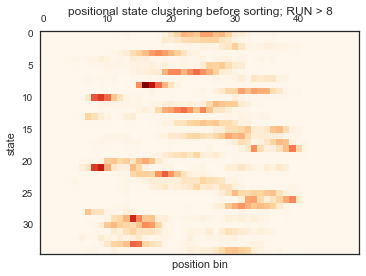

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.matshow(state_pos, interpolation='none', cmap='OrRd')
ax1.set_xlabel('position bin')
ax1.set_ylabel('state')
ax1.set_title('positional state clustering before sorting; RUN > 8')

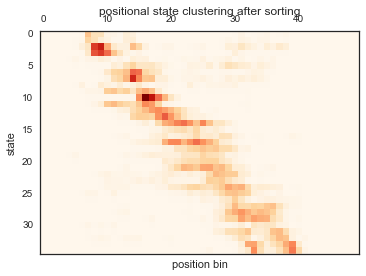

In [7]:
## now order states by peak location on track
peaklocations = state_pos.argmax(axis=1)
peakorder = peaklocations.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.matshow(state_pos[peakorder,:], interpolation='none', cmap='OrRd')
ax1.set_xlabel('position bin')
ax1.set_ylabel('state')
ax1.set_title('positional state clustering after sorting; RUN > 8')

**Remarks:** I am very pleased with the above results; the model states do indeed look like place fields. Note that the animal never explored the track for $x < 10$ or $x>90$. We can perform a similar analysis in 2D if the experiment calls for it, and we should similarly see nice place fields forming in the environment.

The above results were obtained using RUN > 8 data, evaluated (decoded) in a RUN > 8 model. Q. What would happen if we use the same model, but evaluate the NORUN < 4 data? Also, what would happen if we train a model on NORUN < 4 data and evaluate only the corresponding data? It is worth looking at some, or many of these and other combinations, to get a feel for how well the model really picked up on the place-preference of cells, or to what extent other choices in our design influenced the results shown above.

Another interesting feature is that we can actually see that some of the cells (states) shifted place fields when the track was shortened. See e.g. states 30 to 35, where the bifurcation is clearly visible. This claim should be verified more carefully of course, but it seems very plausible.

### Positional state clustering 2: NORUN data only ($< 4$  u$\cdot$s$^{-1}$) @ 62.5 ms bins; $N_s$ = 50 spatial bins; MAP
Here I train and evaluate using NORUN < 4 data. Perhaps 4 units per second is still too fast? I could easily go down to NORUN < 1 or even less. _Ideally_ one might hope to see much less well defined spatial clustering than the above results, but it is certainly possible that place cells are still firing robustly when the animal is stationary in the environment.

In [26]:
# get bins where rat was running slower than thresh units per second
norunidx_0625 = np.where(speed_0625<4)[0]
seq_stk_norun_0625 = extract_subsequences_from_binned_spikes(binned_spikes,norunidx_0625)

## split data into train, test, and validation sets:
tr_q,vl_q,ts_q = sq.data_split(seq_stk_norun_0625, tr=50, vl=2, ts=50, randomseed = 0, verbose=True)

## train HMM on active behavioral data; training set (with a fixed, arbitrary number of states for now):
myhmmq = sq.hmm_train(tr_q, num_states=35, n_iter=50, verbose=False)

Splitting 145 sequences into train, validation, and test sets...
71 sequences being stacked...
Total sequence length: 15544 bins, each of width 0.0625 seconds
Successfully stacked 71 sequences for a total of 971.50 seconds of data.
2 sequences being stacked...
Total sequence length: 527 bins, each of width 0.0625 seconds
Successfully stacked 2 sequences for a total of 32.94 seconds of data.
72 sequences being stacked...
Total sequence length: 19113 bins, each of width 0.0625 seconds
Successfully stacked 72 sequences for a total of 1194.56 seconds of data.
Stacked data split into train (49.0 %), validation (2.0 %) and test (49.0 %) sequences.


In [27]:
###########################################################3
stacked_data = seq_stk_norun_0625
###########################################################3

x0=0; xl=100; num_pos_bins=50
xx_left = np.linspace(x0,xl,num_pos_bins+1)
num_sequences = len(stacked_data.sequence_lengths)
num_states = myhmmq.n_components
state_pos = np.zeros((num_states, num_pos_bins))

for seq_id in np.arange(0,num_sequences):
    tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());
    obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmmq.score_samples(obs)
    xx = truepos_0625[stacked_data.boundaries[seq_id,0]:stacked_data.boundaries[seq_id,1]+1]
    digitized = np.digitize(xx, xx_left) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos[:,digitized[ii]] += np.transpose(ppii)

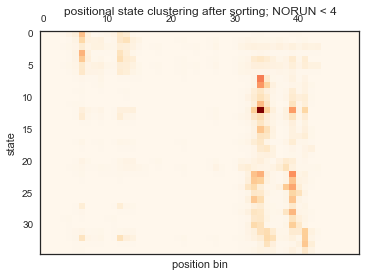

In [28]:
## now order states by peak location on track
peaklocations = state_pos.argmax(axis=1)
peakorder = peaklocations.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.matshow(state_pos[peakorder,:], interpolation='none', cmap='OrRd')
ax1.set_xlabel('position bin')
ax1.set_ylabel('state')
ax1.set_title('positional state clustering after sorting; NORUN < 4')

**Remarks:** We can see that very few place field like structure was found, but the reward locations are robustly encoded, both before and after shortening the track.

### Positional state clustering 3: NORUN data only ($< 1$  u$\cdot$s$^{-1}$) @ 62.5 ms bins; $N_s$ = 50 spatial bins; MAP
Here I train and evaluate using NORUN < 1 data. We should see something very similar to when we were using NORUN < 4 data.

In [29]:
# get bins where rat was running slower than thresh units per second
norunidx_0625 = np.where(speed_0625<1)[0]
seq_stk_norun_0625 = extract_subsequences_from_binned_spikes(binned_spikes,norunidx_0625)

## split data into train, test, and validation sets:
tr_q,vl_q,ts_q = sq.data_split(seq_stk_norun_0625, tr=50, vl=2, ts=50, randomseed = 0, verbose=True)

## train HMM on active behavioral data; training set (with a fixed, arbitrary number of states for now):
myhmmq = sq.hmm_train(tr_q, num_states=35, n_iter=50, verbose=False)

Splitting 397 sequences into train, validation, and test sets...
194 sequences being stacked...
Total sequence length: 7777 bins, each of width 0.0625 seconds
Successfully stacked 194 sequences for a total of 486.06 seconds of data.
7 sequences being stacked...
Total sequence length: 279 bins, each of width 0.0625 seconds
Successfully stacked 7 sequences for a total of 17.44 seconds of data.
196 sequences being stacked...
Total sequence length: 8285 bins, each of width 0.0625 seconds
Successfully stacked 196 sequences for a total of 517.81 seconds of data.
Stacked data split into train (49.0 %), validation (2.0 %) and test (49.0 %) sequences.


In [30]:
###########################################################3
stacked_data = seq_stk_norun_0625
###########################################################3

x0=0; xl=100; num_pos_bins=50
xx_left = np.linspace(x0,xl,num_pos_bins+1)
num_sequences = len(stacked_data.sequence_lengths)
num_states = myhmmq.n_components
state_pos = np.zeros((num_states, num_pos_bins))

for seq_id in np.arange(0,num_sequences):
    tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());
    obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmmq.score_samples(obs)
    xx = truepos_0625[stacked_data.boundaries[seq_id,0]:stacked_data.boundaries[seq_id,1]+1]
    digitized = np.digitize(xx, xx_left) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos[:,digitized[ii]] += np.transpose(ppii)

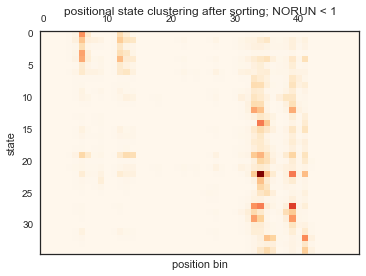

In [31]:
## now order states by peak location on track
peaklocations = state_pos.argmax(axis=1)
peakorder = peaklocations.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.matshow(state_pos[peakorder,:], interpolation='none', cmap='OrRd')
ax1.set_xlabel('position bin')
ax1.set_ylabel('state')
ax1.set_title('positional state clustering after sorting; NORUN < 1')

**Remarks:** Indeed, we again see a robust representation/encoding of the reward sites, and little else. What about stationary data decoded in the RUN model? And what about RUN data in the stationary model? Hopefully, both will reveal no significant place field structure outside of the reward sites, but let's confirm this next.

### Positional state clustering 4: NORUN ($< 1$  u$\cdot$s$^{-1}$) in RUN model @ 62.5 ms bins; $N_s$ = 50 spatial bins; MAP
Here I evaluate NORUN < 1 data in the RUN > 8 model.

In [32]:
###########################################################3
stacked_data = seq_stk_norun_0625
###########################################################3

x0=0; xl=100; num_pos_bins=50
xx_left = np.linspace(x0,xl,num_pos_bins+1)
num_sequences = len(stacked_data.sequence_lengths)
num_states = myhmm.n_components
state_pos = np.zeros((num_states, num_pos_bins))

for seq_id in np.arange(0,num_sequences):
    tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());
    obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmm.score_samples(obs)
    xx = truepos_0625[stacked_data.boundaries[seq_id,0]:stacked_data.boundaries[seq_id,1]+1]
    digitized = np.digitize(xx, xx_left) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos[:,digitized[ii]] += np.transpose(ppii)

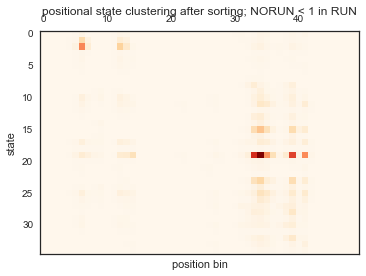

In [33]:
## now order states by peak location on track
peaklocations = state_pos.argmax(axis=1)
peakorder = peaklocations.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.matshow(state_pos[peakorder,:], interpolation='none', cmap='OrRd')
ax1.set_xlabel('position bin')
ax1.set_ylabel('state')
ax1.set_title('positional state clustering after sorting; NORUN < 1 in RUN')

### Positional state clustering 5: RUN ($> 8$  u$\cdot$s$^{-1}$) in NORUN model @ 62.5 ms bins; $N_s$ = 50 spatial bins; MAP
Here I evaluate RUN > 8 data in the NORUN < 1 model.

In [34]:
###########################################################3
stacked_data = seq_stk_run_0625
###########################################################3

x0=0; xl=100; num_pos_bins=50
xx_left = np.linspace(x0,xl,num_pos_bins+1)
num_sequences = len(stacked_data.sequence_lengths)
num_states = myhmmq.n_components
state_pos = np.zeros((num_states, num_pos_bins))

for seq_id in np.arange(0,num_sequences):
    tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());
    obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmmq.score_samples(obs)
    xx = truepos_0625[stacked_data.boundaries[seq_id,0]:stacked_data.boundaries[seq_id,1]+1]
    digitized = np.digitize(xx, xx_left) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos[:,digitized[ii]] += np.transpose(ppii)

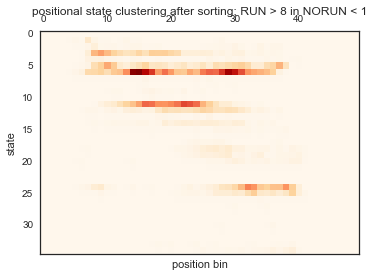

In [35]:
## now order states by peak location on track
peaklocations = state_pos.argmax(axis=1)
peakorder = peaklocations.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.matshow(state_pos[peakorder,:], interpolation='none', cmap='OrRd')
ax1.set_xlabel('position bin')
ax1.set_ylabel('state')
ax1.set_title('positional state clustering after sorting; RUN > 8 in NORUN < 1')

### Positional state clustering 6: ALL data @ 62.5 ms bins; $N_s$ = 50 spatial bins; MAP
What if we don't know when the animal is running, and when it is resting? What if we just inject ALL of the data into the model to learn some underlying states? In this case, we should of course expect to learn states with place field like structures, but also very robust encoding of the reward sites. I expect that the model will do fine, but one potential problem is the fact that the RUN data constitutes a much smaller part of the data than the NORUN data, so that the quiescent color levels might mask the place field activity. I could be more careful in normalizing, or I could use a logarithmic color scale to reveal multi-level structures. Let's see what we get first:

In [38]:
# get bins where rat was running slower than thresh units per second
allidx_0625 = np.where(speed_0625>=0)[0]
seq_stk_all_0625 = extract_subsequences_from_binned_spikes(binned_spikes,allidx_0625)

## train HMM on active behavioral data; training set (with a fixed, arbitrary number of states for now):
myhmmall = sq.hmm_train(seq_stk_all_0625, num_states=35, n_iter=50, verbose=False)

In [83]:
###########################################################3
stacked_data = seq_stk_all_0625
###########################################################3

x0=0; xl=100; num_pos_bins=50
xx_left = np.linspace(x0,xl,num_pos_bins+1)
num_sequences = len(stacked_data.sequence_lengths)
num_states = myhmmall.n_components
state_pos = np.zeros((num_states, num_pos_bins))

for seq_id in np.arange(0,num_sequences):
    tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());
    obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmmall.score_samples(obs)
    xx = truepos_0625[stacked_data.boundaries[seq_id,0]:stacked_data.boundaries[seq_id,1]+1]
    digitized = np.digitize(xx, xx_left) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos[:,digitized[ii]] += np.transpose(ppii)

In [7]:
def normalize_state_pos(state_pos):
    num_states = state_pos.shape[0]
    num_pos_bins = state_pos.shape[1]
    state_pos = state_pos / np.tile(np.reshape(state_pos.sum(axis=1),(num_states,1)),num_pos_bins)
    return state_pos

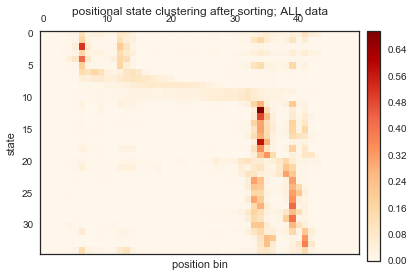

In [84]:
## now order states by peak location on track
state_pos = normalize_state_pos(state_pos)
peaklocations = state_pos.argmax(axis=1)
peakorder = peaklocations.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
im = ax1.matshow(state_pos[peakorder,:], interpolation='none', cmap='OrRd')
ax1.set_xlabel('position bin')
ax1.set_ylabel('state')
ax1.set_title('positional state clustering after sorting; ALL data')
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cax)

**Remarks:** Notice that the majority of the states have been recruited to encode the reward locations, with only a small number of states (6 to 11) representing other positions along the track. This is somewhat disappointing, but ultimately expected, since the majority of the data were spent at the reward locations, and comparatively very little data were collected when running along the track. 

Can we possibly make the track representation better by considering more states?

### Positional state clustering 7: RUN data in an ALL model @ 62.5 ms bins; $N_s$ = 50 spatial bins; MAP
Here we see what we can learn by using a model trained on ALL the data (mostly quiescent data, and a little bit of RUN data), so that most of the states are tuned to encode the reward locations... but this time, we look at the place fields by only evaluating RUN sequences in the ALL-trained model.

In [85]:
###########################################################3
stacked_data = seq_stk_run_0625
###########################################################3

x0=0; xl=100; num_pos_bins=50
xx_left = np.linspace(x0,xl,num_pos_bins+1)
num_sequences = len(stacked_data.sequence_lengths)
num_states = myhmmall.n_components
state_pos = np.zeros((num_states, num_pos_bins))

for seq_id in np.arange(0,num_sequences):
    tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());
    obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmmall.score_samples(obs)
    xx = truepos_0625[stacked_data.boundaries[seq_id,0]:stacked_data.boundaries[seq_id,1]+1]
    digitized = np.digitize(xx, xx_left) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos[:,digitized[ii]] += np.transpose(ppii)

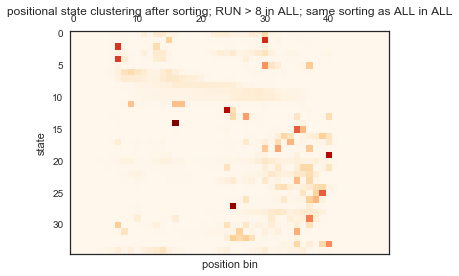

In [88]:
state_pos = normalize_state_pos(state_pos)
#peaklocations = state_pos.argmax(axis=1)
#peakorder = peaklocations.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.matshow(state_pos[peakorder,:], interpolation='none', cmap='OrRd')
ax1.set_xlabel('position bin')
ax1.set_ylabel('state')
ax1.set_title('positional state clustering after sorting; RUN > 8 in ALL; same sorting as ALL in ALL')

**Remarks:** Somewhat surprisingly, we find that a wide range of states now encode the position along the track. Recall that we did not update the ALL model in any way. This is the SAME model as what was used for the ALL in ALL result above, where most of the states encoded reward locations, and only states 6 through 11 seemed to cover the remaining positions on the track. How do we reconcile these two different views of the underlying model? I have to think about it a little more carefully... 

Here we have intentionally not resorted the states, so that we can compare it directly to the ALL in ALL result above. However, if we re-sort the states according to their peak locations along the track, we can better see the almost uniform coverage along the track that was nonetheless learned from the data:

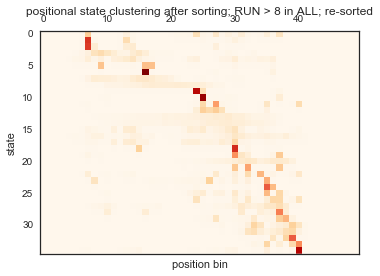

In [90]:
## now order states by peak location on track
state_pos = normalize_state_pos(state_pos)
peaklocations = state_pos.argmax(axis=1)
peakorder = peaklocations.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.matshow(state_pos[peakorder,:], interpolation='none', cmap='OrRd')
ax1.set_xlabel('position bin')
ax1.set_ylabel('state')
ax1.set_title('positional state clustering after sorting; RUN > 8 in ALL; re-sorted')

### Positional state clustering 8: NORUN data in an ALL model @ 62.5 ms bins; $N_s$ = 50 spatial bins; MAP
As a final check, we look at the NORUN < 1 data in the ALL model.

In [91]:
###########################################################3
stacked_data = seq_stk_norun_0625
###########################################################3

x0=0; xl=100; num_pos_bins=50
xx_left = np.linspace(x0,xl,num_pos_bins+1)
num_sequences = len(stacked_data.sequence_lengths)
num_states = myhmmall.n_components
state_pos = np.zeros((num_states, num_pos_bins))

for seq_id in np.arange(0,num_sequences):
    tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());
    obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmmall.score_samples(obs)
    xx = truepos_0625[stacked_data.boundaries[seq_id,0]:stacked_data.boundaries[seq_id,1]+1]
    digitized = np.digitize(xx, xx_left) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos[:,digitized[ii]] += np.transpose(ppii)

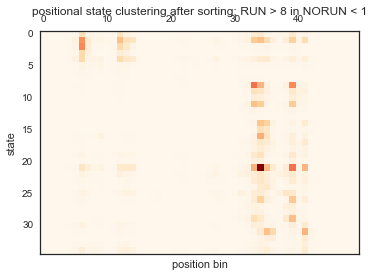

In [92]:
## now order states by peak location on track
peaklocations = state_pos.argmax(axis=1)
peakorder = peaklocations.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.matshow(state_pos[peakorder,:], interpolation='none', cmap='OrRd')
ax1.set_xlabel('position bin')
ax1.set_ylabel('state')
ax1.set_title('positional state clustering after sorting; NORUN <1 in ALL')

**Remarks:** Perhaps unsurprisingly this time, we see results very similar to the NORUN results presented earlier. Indeed, the ALL model consists of mostly NORUN data, so evaluating the NORUN data in the ALL model should be very similar to evaluating NORUN data in a NORUN model. No surprises here, and things are as expected.

**Discussion:** In conclusion I think it is safe to say that the HMM effectively learned behaviorally relevant states, especially when presented with RUN data. However, even when given ALL the data, the model somehow still captured state representations for both (i) the reward locations, as well as (positions along the track).

Next, we see if we can represent the track better by using more model states.

### Positional state clustering 9: ALL data @ 62.5 ms bins; $N_s$ = 50 spatial bins; MAP; 55 states
Previously we saw that around 5–6 states were recruited to represent positions along the track when we used $m=35$ model states and all the data. If we increase the model states to $m=55$, what should we expect? Perhaps we should expect a linear increase in the number of states representing the positions along the track, so that we should expect 10–11 states to represent positions between the reward locations.

In [8]:
# get bins where rat was running slower than thresh units per second
allidx_0625 = np.where(speed_0625>=0)[0]
seq_stk_all_0625 = extract_subsequences_from_binned_spikes(binned_spikes,allidx_0625)

## train HMM on active behavioral data; training set (with a fixed, arbitrary number of states for now):
myhmmall = sq.hmm_train(seq_stk_all_0625, num_states=55, n_iter=50, verbose=False)

In [9]:
###########################################################3
stacked_data = seq_stk_all_0625
###########################################################3

x0=0; xl=100; num_pos_bins=50
xx_left = np.linspace(x0,xl,num_pos_bins+1)
num_sequences = len(stacked_data.sequence_lengths)
num_states = myhmmall.n_components
state_pos = np.zeros((num_states, num_pos_bins))

for seq_id in np.arange(0,num_sequences):
    tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());
    obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmmall.score_samples(obs)
    xx = truepos_0625[stacked_data.boundaries[seq_id,0]:stacked_data.boundaries[seq_id,1]+1]
    digitized = np.digitize(xx, xx_left) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos[:,digitized[ii]] += np.transpose(ppii)

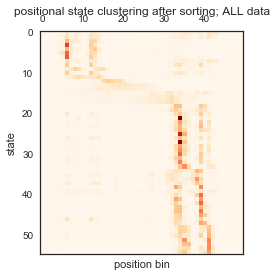

In [17]:
## now order states by peak location on track
state_pos = normalize_state_pos(state_pos)
peaklocations = state_pos.argmax(axis=1)
peakorder = peaklocations.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.matshow(state_pos[peakorder,:], interpolation='none', cmap='OrRd')
ax1.set_xlabel('position bin')
ax1.set_ylabel('state')
ax1.set_title('positional state clustering after sorting; ALL data')

**Remarks:** Indeed, we found a linear increase in the number of states representing the positions along the track. The proportion of states encoding this part of the behavior (running along the track) is also _roughly_ consistent with the proportion of data: The animal ran faster than th = 8.0 units/s for a total of 237.7 seconds (out of a total of 2587.8 seconds) That is around 10 % of the time, but quiescent data are also expected to be more homogeneous, so that fewer states have to be recruited to capture the underlying dynamics.

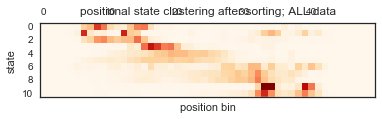

In [16]:
## now order states by peak location on track
state_pos = normalize_state_pos(state_pos)
peaklocations = state_pos.argmax(axis=1)
peakorder = peaklocations.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.matshow(state_pos[peakorder[9:20],:], interpolation='none', cmap='OrRd')
ax1.set_xlabel('position bin')
ax1.set_ylabel('state')
ax1.set_title('positional state clustering after sorting; ALL data')


## Part 2: Categorical state clustering